## Spell Decoder - Setup and Simulations


In [26]:
import numpy as np
import scipy
from sklearn import datasets
import matplotlib.pyplot as plt

## Assumptions (simplest case)
Let $C \in \mathbb N$ be the number of `channels` and $T \in \mathbb N$ be the number of sampled `time points` and $\mathcal S$ be the set of `spells`.

We assume that a single trial $X$ has the following properties:
- Weakly stationary stochastic process: $X = (X_t)_{t = 1, \ldots,  T}$ with $X_t \in \mathbb R^{C}$ and $\mathbb E[X_t | s] = a_s$ (regardless of $t$)
- Stable VAR(1) structure: $X_t|s = a_s + \mathbf A_s X_{t-1} + U_t$ with $\,\mathbb E[U_t] = 0, \; \mathbb E[U_tU_t^\top] = \boldsymbol \Sigma, \; \underset{k \neq t}{\forall} \; \mathbb E[U_tU_k^\top] = \mathbf 0$, and all eigenvalues of $A_s$ have modulus less than 1.

Then there exists a maximum likelihood estimator for $ B_s = (a_s, \mathbf A_s)$ with $\mathbf{Z = (Z_0, \ldots, Z_{T-1})}, \; \mathbf{Z_t = (1, X_t)^\top}$: $\hat B_s = \mathbf{XZ^\top(ZZ^\top)^{-1}}$.

### 0. The Data

In [27]:
nChan = 102 # number of magnetometer channels
nObs = 30 
nSeconds = 5
Hz = 20
nSamples = nSeconds * Hz # 5 seconds of data at 20 Hz
nSpells = 3
snr = .3

In [28]:
def plotMat(matrix: np.ndarray, title: str) -> None:
    fig, ax = plt.subplots()
    plt.imshow(matrix, cmap='viridis')
    plt.title(title)
    plt.colorbar()
    ax.xaxis.tick_top()

def genNoiseCovariance(nChan: int, var:float, cov:float) -> np.ndarray:
    variance = var * np.eye(nChan)
    covariance = cov * datasets.make_spd_matrix(nChan)
    return variance + covariance


def genPDMat(n: int) -> np.ndarray:
    A = np.random.randint(10, size=(n, n))
    _, eigenvectors = np.linalg.eig(A)
    eigenvalues = np.random.uniform(low=-1., high=1., size=n)
    pdmat = eigenvectors @ np.diag(eigenvalues) @ np.linalg.inv(eigenvectors)
    return np.real(pdmat)

var = 10.
sigma = genNoiseCovariance(nChan, 10., 5.)
mus = [np.random.randint(low=-(var * snr), high=(var * snr), size=nChan) for _ in range(nSpells)]
As = [genPDMat(nChan) for _ in range(nSpells)]


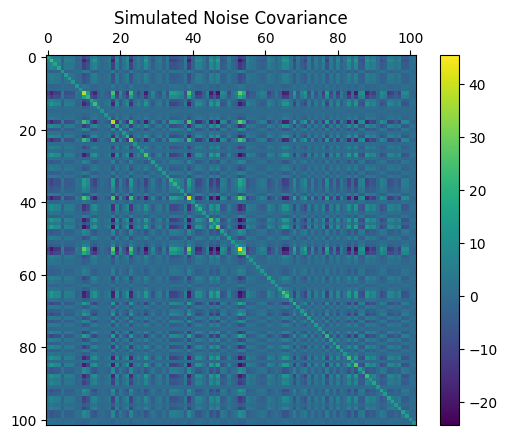

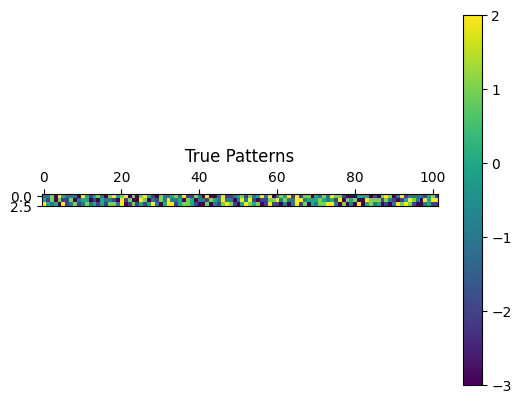

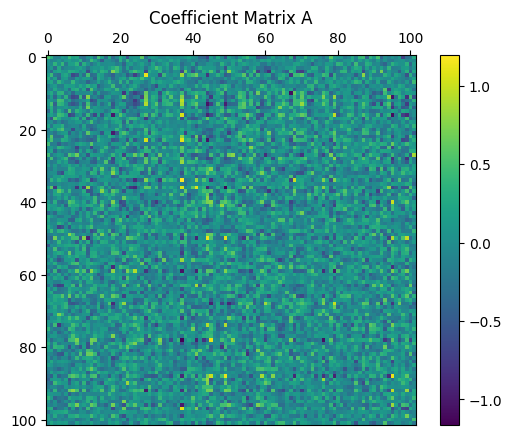

In [29]:
plotMat(sigma, "Simulated Noise Covariance")
plotMat(mus, "True Patterns")
plotMat(As[0], "Coefficient Matrix A")

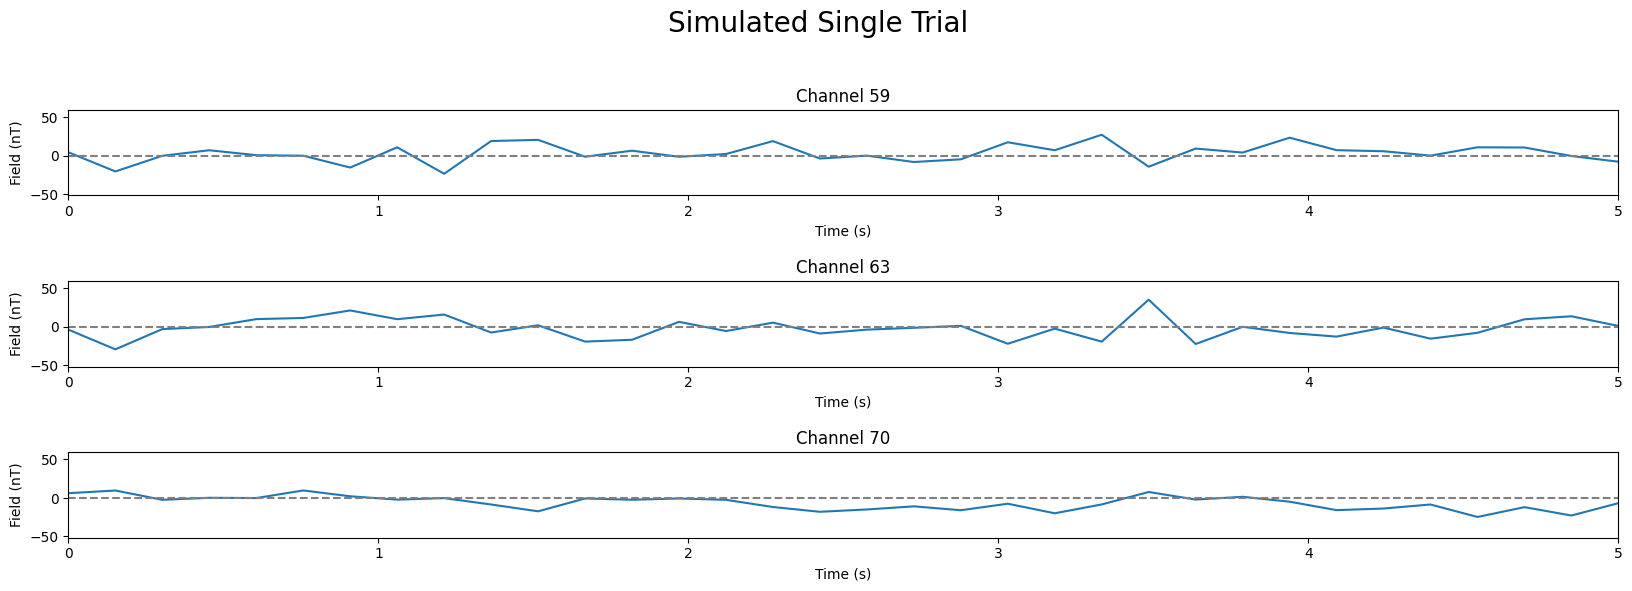

In [30]:
def genVAR(nChan: int, nSamples: int, mu: np.ndarray, sigma: np.ndarray, A: np.ndarray, irf: np.ndarray) -> np.ndarray:
    x = np.zeros((nChan, nSamples))
    x += np.outer(mu, irf)
    noise = np.random.multivariate_normal(np.zeros(nChan), sigma, size=nSamples).T
    x[:,0] += noise[:,0]
    for t in range(1, nSamples):
        x[:,t] += A @ x[:,t-1] + noise[:,t] 
    return x

def plotSomeChannels(x: np.ndarray, nPlots:int, nChan: int, nSamples: int) -> None:
    channels = sorted(np.random.choice(nChan, size=nPlots, replace=False))
    plt.figure(figsize=(20,10))
    plt.suptitle("Simulated Single Trial", fontsize=20)
    t = np.linspace(0, 15, nSamples)

    for i, c in enumerate(channels):
        plt.subplot(5, 1, i+1)
        plt.plot(t, x[c,:])
        plt.title(f"Channel {c}")
        plt.xlabel("Time (s)")
        plt.ylabel("Field (nT)")   
        plt.xlim([0, nSeconds])
        plt.ylim([np.min(x[channels,:]), np.max(x[channels,:])])
        plt.plot(t, np.ones(nSamples) * [0], color='grey', linestyle='--')
        plt.subplots_adjust(hspace=1.)

_, irf = scipy.signal.impulse(([1.0], [1.0, 2.0, 2.0]), N=nSamples)
x = genVAR(nChan, nSamples, mus[0], sigma, As[0], irf)
plotSomeChannels(x, 3, nChan, nSamples)

Let us now generate data and check if we build a multinomial classifier based on them:

In [31]:
from sklearn.model_selection import KFold
# from sklearn.model_selection import train_test_split
X_0 = [genVAR(nChan, nSamples, mus[0], sigma, As[0], irf) for _ in range(nObs)]
X_1 = [genVAR(nChan, nSamples, mus[1], sigma, As[1], irf) for _ in range(nObs)]
X_2 = [genVAR(nChan, nSamples, mus[2], sigma, As[2], irf) for _ in range(nObs)]
X = np.array(X_0 + X_1 + X_2) 
y = np.array(["0"] * nObs + ["1"] * nObs + ["2"] * nObs)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False) 

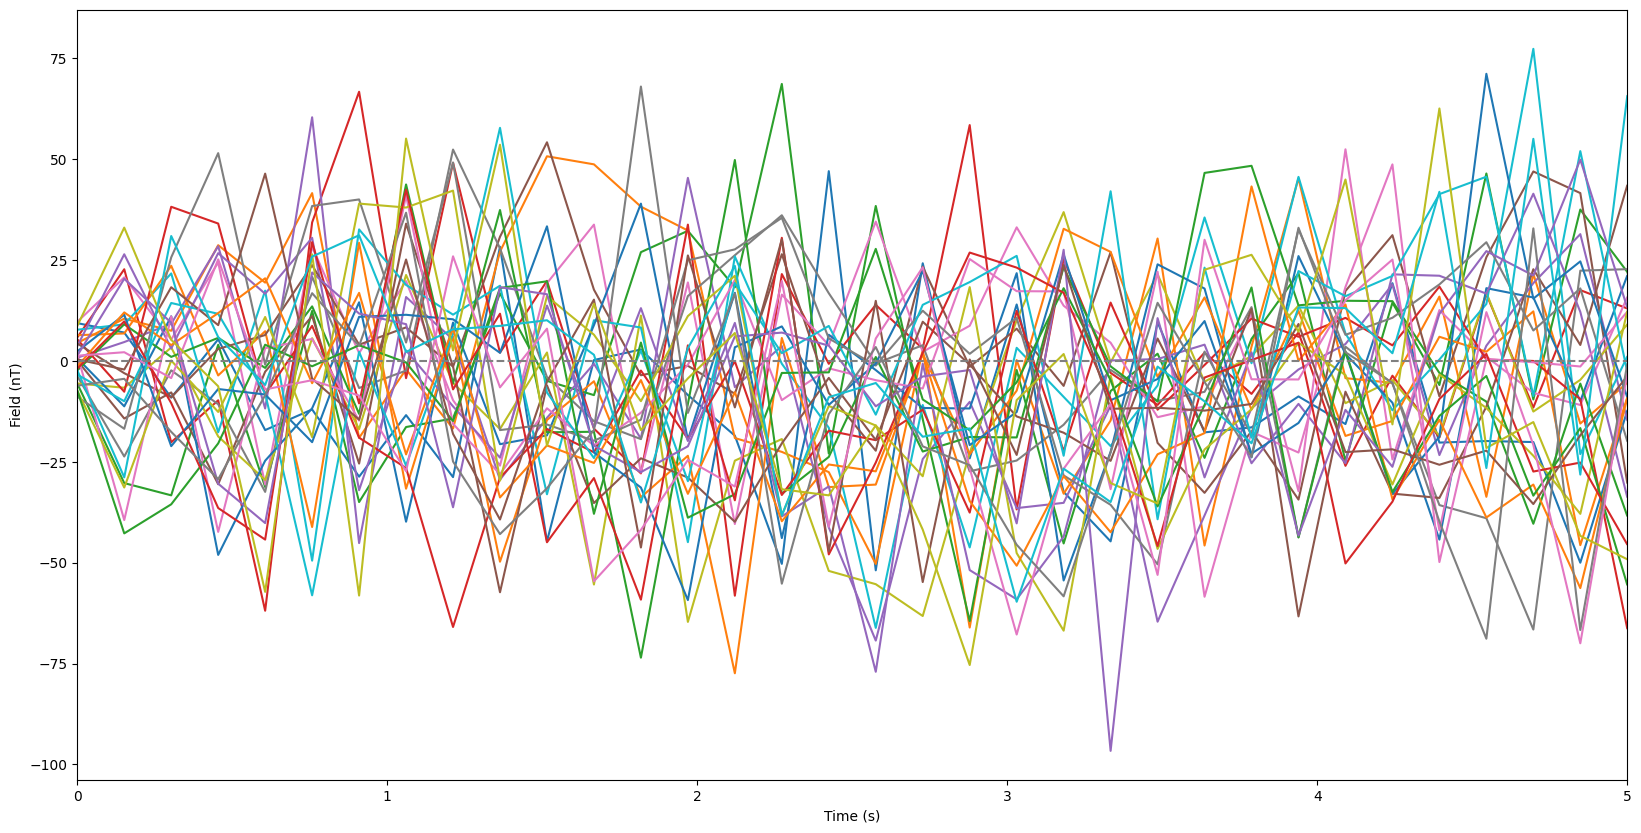

In [32]:
# plot multiple trials of the same channel
def plotChannel(x: np.ndarray, channel: int) -> None:
    x = np.array(x)
    plt.figure(figsize=(20,10))
    t = np.linspace(0, 15, nSamples)
    n = x.shape[0]
    for trial in range(n):
        plt.plot(t, x[trial, channel, :])
    plt.xlabel("Time (s)")
    plt.ylabel("Field (nT)")   
    plt.xlim([0, nSeconds])
    plt.ylim([np.min(x[:,channel,:]), np.max(x[:,channel,:])])
    plt.plot(t, np.ones(nSamples) * [0], color='grey', linestyle='--')

plotChannel(X_1, 1)


In [33]:
from sklearn.linear_model import LogisticRegression    
from sklearn.model_selection import cross_validate, KFold
mnc = LogisticRegression(multi_class='multinomial', solver='newton-cg', penalty='l2')
kf = KFold(n_splits=10, shuffle=False)

def kfoldCV(X, y, model, kf):
    train_scores = []
    test_scores = []
    nSamples = X.shape[2]
    for i in range(nSamples):
        print(f"Training on time point {i+1} of {nSamples}")
        x = X[:,:,i]
        scores = cross_validate(model, x, y, cv=kf, scoring='accuracy', return_train_score=True)
        train_scores.append(scores['train_score'].mean())
        test_scores.append(scores['test_score'].mean())
    return np.array(train_scores), np.array(test_scores)

train_scores, test_scores = kfoldCV(X, y, mnc, kf)
    

Training on time point 1 of 100
Training on time point 2 of 100
Training on time point 3 of 100
Training on time point 4 of 100
Training on time point 5 of 100
Training on time point 6 of 100
Training on time point 7 of 100
Training on time point 8 of 100
Training on time point 9 of 100
Training on time point 10 of 100
Training on time point 11 of 100
Training on time point 12 of 100
Training on time point 13 of 100
Training on time point 14 of 100
Training on time point 15 of 100
Training on time point 16 of 100
Training on time point 17 of 100
Training on time point 18 of 100
Training on time point 19 of 100
Training on time point 20 of 100
Training on time point 21 of 100
Training on time point 22 of 100
Training on time point 23 of 100
Training on time point 24 of 100
Training on time point 25 of 100
Training on time point 26 of 100
Training on time point 27 of 100
Training on time point 28 of 100
Training on time point 29 of 100
Training on time point 30 of 100
Training on time po

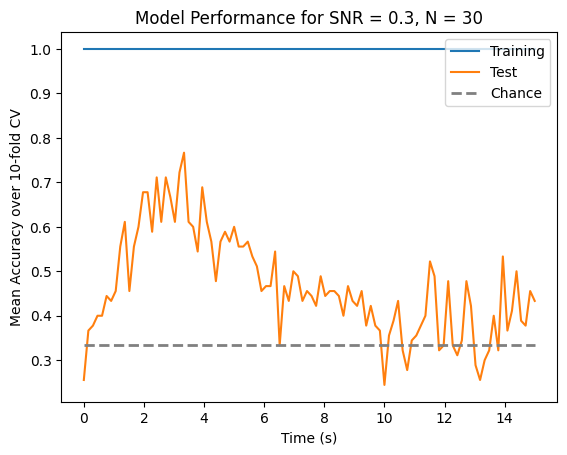

In [35]:
plt.plot(np.linspace(0, 15, nSamples), train_scores)
plt.plot(np.linspace(0, 15, nSamples), test_scores)
plt.plot([0, 15], [1/nSpells, 1/nSpells], color='grey', linestyle='--', linewidth=2)
plt.xlabel("Time (s)")
plt.ylabel("Mean Accuracy over 10-fold CV")
plt.title(f"Model Performance for SNR = {snr}, N = {nObs} per class")
plt.legend(["Training", "Test", "Chance"], loc='upper right')

